# Dependencies

## Download Python and pip

If Python or its package manager pip aren't installed, click the links below and follow the installation tutorials:
<br>
https://www.python.org/downloads/
<br>
https://pip.pypa.io/en/stable/installation/

## Importing libraries 

In [1288]:
%pip install pandas numpy matplotlib seaborn python-metar geopy scikit-learn xgboost optuna


Note: you may need to restart the kernel to use updated packages.


In [1289]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from geopy.distance import geodesic
from metar import Metar
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna
from datetime import datetime
from statistics import mode
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sns.set_theme()

# API requests

The code below is designed to extract data from the API provided by ITA (Instituto Tecnológico de Aeronáutica),
a prestigious college located in Brazil. The API offers comprehensive information about flights, including
meteorological data, radar snapshots, as well as details about the origin and destination of each flight.
This data can be used for a wide range of applications related to aviation. In this case, it's being used to create a machine learning model that predicts the Estimated Landing Time (ELDT) for each flight given its conditions.

In [1290]:
# path = './data'

# try:
#     os.mkdir(path)
# except FileExistsError:
#     print('Directory already exists.')

In [1291]:

# token = 'a779d04f85c4bf6cfa586d30aaec57c44e9b7173'

# initial_date = '2022-06-01'
# final_date = '2022-08-01'

# def load_csv(df, endpoint_name):
#     df.to_csv(f'data/{endpoint_name}.csv', index=False)
#     print(f'Dados de {endpoint_name} salvos em um arquivo CSV com sucesso!')
#     return df

# def api_request(endpoint, initial_date=initial_date, final_date=final_date, token=token):
#     url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + str(endpoint) + '?token=' + str(token) + '&idate=' + str(initial_date) + '&fdate=' + str(final_date)

#     res = requests.get(url)
    
#     if res.status_code == 200:
#         req = res.json()
#         df = pd.DataFrame(req)
#         return df
#     else:
#         print(f'Falha na solicitação de {endpoint}. Código de status:', res.status_code)

# endpoints_array = ['bimtra', 'esperas', 'metaf', 'metar', 'tc-prev', 'tc-real']

# for endpoint in endpoints_array:
#     df = api_request(endpoint)
#     load_csv(df, endpoint)

In [1292]:
# initial_dates_cat_62 = ['2022-06-01 00:00:00.000',
#                         '2022-06-15 00:00:00.000',
#                         '2022-06-25 00:00:00.000',
#                         '2022-07-05 00:00:00.000',
#                         '2022-07-10 00:00:00.000',
#                         '2022-07-20 00:00:00.000']

# final_dates_cat_62 = ['2022-06-15 00:00:00.000',
#                       '2022-06-25 00:00:00.000',
#                       '2022-07-05 00:00:00.000',
#                       '2022-07-10 00:00:00.000',
#                       '2022-07-20 00:00:00.000',
#                       '2022-08-01 00:00:00.000']

# for i, (initial_date, final_date) in enumerate(zip(initial_dates_cat_62, final_dates_cat_62)):
#     if i == 0:
#         cat_62_general = api_request('cat-62', initial_date, final_date)
#         print(f'{i+1} download out of 6 done!')
#     else:
#         cat_62_general = pd.concat([cat_62_general, api_request('cat-62', initial_date, final_date)])
#         print(f'{i+1} downloads out of 6 done!')


# load_csv(cat_62_general, 'cat-62')

## Loading data

In [1293]:
bimtra_df = pd.read_csv('data/bimtra.csv')
esperas_df = pd.read_csv('data/esperas.csv')
metaf_df = pd.read_csv('data/metaf.csv')
metar_df = pd.read_csv('data/metar.csv')
tc_prev_df = pd.read_csv('data/tc-prev.csv')
tc_real_df = pd.read_csv('data/tc-real.csv')
test_data = pd.read_csv('data/idsc_dataset2.csv', ';')
cat_62 = pd.read_csv('data/cat-62.csv')

/var/folders/fm/hfnbr04d267874fqpqtzz09w0000gn/T/ipykernel_34438/590347478.py:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  test_data = pd.read_csv('data/idsc_dataset2.csv', ';')


# Exploratory Analysis

In [1294]:
test_data.head()

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,11:53:30,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,11:00:00,METAF SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,00:04:37,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,00:00:00,METAF SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,01:33:15,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,01:00:00,METAF SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,03:54:14,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,NaN,NaN,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,00:27:32,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,00:00:00,METAF SBGR 230000Z 32008KT CAVOK 24/04 Q1010=\n,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR


In [1295]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40039 entries, 0 to 40038
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flightid        40039 non-null  object 
 1   origem          40039 non-null  object 
 2   destino         40039 non-null  object 
 3   hora_ref        40039 non-null  object 
 4   dt_dep          40039 non-null  object 
 5   snapshot_radar  37465 non-null  object 
 6   path            38870 non-null  object 
 7   hora_esperas    40039 non-null  object 
 8   esperas         40039 non-null  int64  
 9   aero_esperas    40039 non-null  object 
 10  hora_metaf      34705 non-null  object 
 11  metaf           34705 non-null  object 
 12  aero_metaf      34705 non-null  object 
 13  hora_metar      39113 non-null  object 
 14  metar           39113 non-null  object 
 15  aero_metar      39113 non-null  object 
 16  hora_tcp        39058 non-null  object 
 17  troca           39058 non-null 

In [1296]:
test_data.describe()

,esperas,troca
count,40039.000000,39058.0
mean,0.226654,0.0
std,1.243898,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,37.000000,0.0


In [1297]:
test_data.snapshot_radar.sample(1)

3653    MULTIPOINT ((-0.8957167482552626 -0.5233981204...
Name: snapshot_radar, dtype: object

In [1298]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'hora_ref', 'dt_dep', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [1299]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,11:53:30,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,11:00:00,METAF SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,00:04:37,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,00:00:00,METAF SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,01:33:15,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,01:00:00,METAF SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,03:54:14,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,NaN,NaN,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,00:27:32,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,00:00:00,METAF SBGR 230000Z 32008KT CAVOK 24/04 Q1010=\n,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [1300]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'hora_ref', 'dt_dep', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [1301]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')
print(f'cat_62: {cat_62.shape}')

bimtra_df: (48821, 5)
esperas_df: (17856, 3)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)
cat_62: (6102640, 6)


# Pre Processing

In [1302]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [1303]:
bimtra_df['solution'].describe()

count    48821.000000
mean      4691.582372
std       2534.483202
min     -83541.000000
25%       2940.000000
50%       4112.000000
75%       5457.000000
max      19408.000000
Name: solution, dtype: float64

In [1304]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541
1621,a8682cab7acc8720963b1bcf100e8e14,SBFL,SBSP,1654300317000,1654217151000,-83166
43358,8a053ceddd5cd22a111236b4975b990b,SBSP,SBCF,1658876193000,1658793794000,-82399
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133
43121,8bbeac6a115b8eed176d85126e5c4b98,SBBR,SBSP,1658876568000,1658795244000,-81324


In [1305]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) #& (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [1306]:
bimtra_df['solution'].describe()

count    48654.000000
mean      4718.399885
std       2303.360210
min       2002.000000
25%       2947.000000
50%       4130.500000
75%       5467.000000
max      19408.000000
Name: solution, dtype: float64

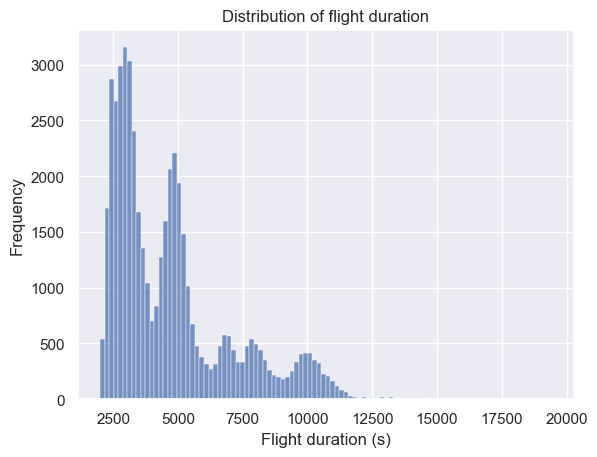

In [1307]:
sns.histplot(bimtra_df['solution'], bins=100)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (s)')
plt.ylabel('Frequency')
plt.show()

In [1308]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [1309]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [1310]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [1311]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(6167, 4)

In [1312]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [1313]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [1314]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (48654, 7)
esperas_df: (17856, 5)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)


In [1315]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [1316]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [1317]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [1318]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
9604,c7df283278024946b8728d56a5c97f64,SBRF,SBKP,2022-06-12 06:20:47,2022-06-12 11:44:15,19408,2022-06-12 06:00:00,0,SBKP,2022-06-12 06:00:00,0,SBKP,2022-06-12 06:00:00,NaN,NaN,NaN,NaT
10043,62c090eda03aeadea59132d5274c4fdf,SBKP,SBRF,2022-06-12 14:14:23,2022-06-12 18:47:57,16414,2022-06-12 14:00:00,0,SBRF,2022-06-12 14:00:00,1,SBRF,2022-06-12 14:00:00,NaN,NaN,NaN,NaT
32075,fd0a325b8a572f4a4276bd40c1873d91,SBRF,SBSP,2022-07-08 18:00:22,2022-07-08 22:22:49,15747,2022-07-08 18:00:00,1,SBSP,2022-07-08 18:00:00,0,SBSP,2022-07-08 18:00:00,17R,18,SBSP,2022-07-08 18:07:54
34641,084058b321a1c59936e4ccfaf56c0f4d,SBRF,SBPA,2022-07-11 03:26:42,2022-07-11 07:39:13,15151,2022-07-11 03:00:00,0,SBPA,2022-07-11 03:00:00,0,SBPA,2022-07-11 03:00:00,NaN,NaN,NaN,NaT
52724,cef74bfcfd439408b3810357e3a27a22,SBRF,SBPA,2022-07-30 03:20:34,2022-07-30 07:32:36,15122,2022-07-30 03:00:00,0,SBPA,2022-07-30 03:00:00,0,SBPA,2022-07-30 03:00:00,NaN,NaN,NaN,NaT
42765,ab2c103f7c33b5249e2e87817725f8aa,SBRF,SBPA,2022-07-20 04:27:54,2022-07-20 08:39:34,15100,2022-07-20 04:00:00,0,SBPA,2022-07-20 04:00:00,0,SBPA,2022-07-20 04:00:00,NaN,NaN,NaN,NaT
21021,5e3fbe85bc19027157aa1f2953213ca4,SBRF,SBPA,2022-06-26 05:39:22,2022-06-26 09:50:55,15093,2022-06-26 05:00:00,0,SBPA,2022-06-26 05:00:00,0,SBPA,2022-06-26 05:00:00,NaN,NaN,NaN,NaT
51441,79dbc16906304d77499c10cbc9ac25e7,SBRF,SBPA,2022-07-29 02:43:20,2022-07-29 06:51:26,14886,2022-07-29 02:00:00,0,SBPA,2022-07-29 02:00:00,1,SBPA,2022-07-29 02:00:00,NaN,NaN,NaN,NaT
45081,1a9c1977a061425b67cf0816031826ae,SBRF,SBPA,2022-07-22 02:54:21,2022-07-22 07:01:56,14855,2022-07-22 02:00:00,0,SBPA,2022-07-22 02:00:00,0,SBPA,2022-07-22 02:00:00,NaN,NaN,NaN,NaT
33062,1ba1ecbc5a78a4db515efc094e4eaa34,SBRF,SBPA,2022-07-09 03:58:23,2022-07-09 08:05:57,14854,2022-07-09 03:00:00,0,SBPA,2022-07-09 03:00:00,0,SBPA,2022-07-09 03:00:00,NaN,NaN,NaN,NaT


In [1319]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
17572,9b072afea3356a907df931674a4e76b3,SBCT,SBRJ,2022-06-22 18:51:15,2022-06-22 19:51:45,3630,2022-06-22 18:00:00,0,SBRJ,2022-06-22 18:00:00,0,SBRJ,2022-06-22 18:00:00,NaN,NaN,NaN,NaT
18201,01abfbfad90dfd25a1387616bb4e48c4,SBGR,SBPA,2022-06-22 01:13:51,2022-06-22 02:42:26,5315,2022-06-22 01:00:00,0,SBPA,2022-06-22 01:00:00,1,SBPA,2022-06-22 01:00:00,11,29,SBPA,2022-06-22 01:22:14
12405,cbb492549b1f36b7ab6bbd134539acdf,SBGR,SBPA,2022-06-15 21:40:38,2022-06-15 23:00:20,4782,2022-06-15 21:00:00,0,SBPA,2022-06-15 21:00:00,0,SBPA,2022-06-15 21:00:00,NaN,NaN,NaN,NaT
38572,1ef34f7b5e32f0c3bb78af56f6cdc9fc,SBKP,SBFL,2022-07-15 21:00:41,2022-07-15 21:55:29,3288,2022-07-15 21:00:00,0,SBFL,2022-07-15 21:00:00,1,SBFL,2022-07-15 21:00:00,NaN,NaN,NaN,NaT
30388,72c5548b146bb68fd7899f925f42b878,SBRJ,SBSP,2022-07-06 21:53:00,2022-07-06 22:32:34,2374,2022-07-06 21:00:00,0,SBSP,2022-07-06 21:00:00,0,SBSP,2022-07-06 21:00:00,35R,16,SBSP,2022-07-06 21:08:35
44937,5fb7aede26d4a6a4f3929df6bf0fea7d,SBRJ,SBBR,2022-07-22 18:59:56,2022-07-22 20:28:04,5288,2022-07-22 18:00:00,0,SBBR,2022-07-22 18:00:00,0,SBBR,2022-07-22 18:00:00,NaN,NaN,NaN,NaT
29291,85e4095d1de6b25743669ccb204b915f,SBCT,SBGR,2022-07-05 20:54:10,2022-07-05 21:42:51,2921,2022-07-05 20:00:00,0,SBGR,2022-07-05 20:00:00,1,SBGR,2022-07-05 20:00:00,NaN,NaN,NaN,NaT
470,0f083b3d5dda8037d89abdcfcb0f7f88,SBFL,SBGR,2022-06-01 21:11:57,2022-06-01 22:18:13,3976,2022-06-01 21:00:00,0,SBGR,2022-06-01 21:00:00,1,SBGR,2022-06-01 21:00:00,NaN,NaN,NaN,NaT
20930,cf180a01b7f4643c63be40d1be8463d1,SBRJ,SBSV,2022-06-25 01:24:32,2022-06-25 03:01:25,5813,2022-06-25 01:00:00,0,SBSV,2022-06-25 01:00:00,0,SBSV,2022-06-25 01:00:00,NaN,NaN,NaN,NaT
51574,e689010b48a996db00902aa3ef26ac68,SBRF,SBCF,2022-07-29 20:41:16,2022-07-29 22:54:51,8015,2022-07-29 20:00:00,0,SBCF,2022-07-29 20:00:00,1,SBCF,2022-07-29 20:00:00,NaN,NaN,NaN,NaT


(54921, 17)

In [1320]:
train_data.isna().sum() 

flightid                0
origem                  0
destino                 0
dt_dep                  0
dt_arr                  0
solution                0
hora_ref                0
esperas                 0
aero_esperas            0
hora_esperas            0
troca                   0
aero_tcp                0
hora_tcp                0
nova_cabeceira      37435
antiga_cabeceira    37435
aero_tcr            37435
hora_tcr            37435
dtype: int64

In [1321]:
train_data.shape

(54921, 17)

In [1322]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [1323]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [1324]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [1325]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,2023-10-06 11:00:00,11,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,11:00:00,METAF SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,00:00:00,METAF SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,2023-10-06 01:00:00,1,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,01:00:00,METAF SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,2023-10-06 03:00:00,3,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,NaN,NaN,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,00:00:00,METAF SBGR 230000Z 32008KT CAVOK 24/04 Q1010=\n,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR


## METAR and METAF decoding

In [1326]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [1327]:
def process_metar(report):
    if isinstance(report, str):  # Check if 'report' is a string
        report = report.replace('=', '')
        try:
            report = Metar.Metar(report)
            return (
                report.temp.value(),
                report.dewpt.value(),
                report.wind_dir.value(),
                report.vis.value(),
                report.wind_speed.value(),
                report.press.value()
            )
        except:
            return (None, None, None, None, None, None)
    else:
        return (None, None, None, None, None, None)

# Assuming 'test_data' is your DataFrame
test_data[['temperature_real', 'dew_point_real', 'wind_direction_real', 'visibility_real', 'wind_speed_real', 'pressure_real']] = test_data['metar'].apply(process_metar).apply(pd.Series)


In [1328]:
test_data.metaf

0        METAF SBSP 211100Z  32007KT 9999       SCT033 ...
1        METAF SBCT 150000Z  11008KT 1000     BR OVC033...
2        METAF SBPA 030100Z 08005KT 9999       SCT011  ...
3                                                      NaN
4         METAF SBGR 230000Z  32008KT CAVOK 24/04 Q1010=\n
                               ...                        
40034                                                  NaN
40035     METAF SBSP 090800Z  36003KT CAVOK 19/10 Q1017=\n
40036     METAF SBCF 221100Z  13004KT CAVOK 21/09 Q1016=\n
40037     METAF SBGR 231200Z  34010KT CAVOK 25/07 Q1012=\n
40038    METAF SBPA 050000Z  20006KT 2000     BR OVC033...
Name: metaf, Length: 40039, dtype: object

In [1329]:
test_data.metaf = test_data.metaf.fillna('')

In [1330]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [1331]:
metaf_df.shape

(5384, 3)

In [1332]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [1333]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [1334]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
736,2022-07-07 14:00:00,METAR SBGL 071400Z 12002KT CAVOK 23/15 Q1022,SBGL,23.0,15.0,120.0,10000.0,2.0,1022.0
4692,2022-07-04 04:00:00,METAR SBSP 040400Z 05004KT CAVOK 17/09 Q1021,SBSP,17.0,9.0,50.0,10000.0,4.0,1021.0
3065,2022-06-22 01:00:00,METAR SBKP 220100Z 04008KT CAVOK 20/13 Q1017,SBKP,20.0,13.0,40.0,10000.0,8.0,1017.0
2770,2022-06-07 13:00:00,METAR SBKP 071300Z 36007KT CAVOK 21/12 Q1014,SBKP,21.0,12.0,360.0,10000.0,7.0,1014.0
241,2022-06-14 09:00:00,METAR SBGL 140900Z 29008KT 9999 BKN028 ...,SBGL,17.0,13.0,290.0,10000.0,8.0,1021.0


In [1335]:
metaf_df.shape

(5384, 9)

In [1336]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [1337]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(18358, 18)

In [1338]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [1339]:
train_data.shape

(54921, 17)

In [1340]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [1341]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

In [1342]:
test_data

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,2023-10-06 11:00:00,11,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,11:00:00,METAR SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN,18.0,13.0,340.0,10000.0,7.0,1016.0,18.0,13.0,320.0,10000.0,7.0,1014.0
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,00:00:00,METAR SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT,11.0,6.0,130.0,10000.0,5.0,1020.0,11.0,10.0,110.0,1000.0,8.0,1020.0
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,2023-10-06 01:00:00,1,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,01:00:00,METAR SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN,21.0,18.0,70.0,9000.0,4.0,1009.0,21.0,16.0,80.0,10000.0,5.0,1010.0
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,2023-10-06 03:00:00,3,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,NaN,,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV,25.0,22.0,60.0,10000.0,9.0,1016.0,None,None,None,None,None,None
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,00:00:00,METAR SBGR 230000Z 32008KT CAVOK 24/04 Q1010,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR,NaN,NaN,NaN,NaN,NaN,NaN,24.0,4.0,320.0,10000.0,8.0,1010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40034,4e08052066073297c7a3c55798618324,SBSV,SBRF,2023-10-06 20:00:00,20,MULTIPOINT ((-0.8955415064673201 -0.5234137952...,http://satelite.cptec.inpe.br/repositoriogoes/...,19:00:00,0,SBRF,NaN,,NaN,19:00:00,METAR SBRF 181900Z 19015KT 9999 SCT023 BKN060 ...,SBRF,20:00:00,0.0,SBRF,NaN,NaN,27.0,22.0,190.0,10000.0,15.0,1013.0,None,None,None,None,None,None
40035,e22f120c65f5759aa8df576b59d71be3,SBCT,SBSP,2023-10-06 08:00:00,8,MULTIPOINT ((-0.8903194203987348 -0.5144905777...,http://satelite.cptec.inpe.br/repositoriogoes/...,07:00:00,0,SBSP,08:00:00,METAR SBSP 090800Z 36003KT CAVOK 19/10 Q1017,SBSP,07:00:00,METAR SBSP 090700Z AUTO VRB02KT CAVOK 19/17 Q1...,SBSP,08:00:00,0.0,SBSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,10.0,360.0,10000.0,3.0,1017.0
40036,ca9399162037201a4d0c49c832a32739,SBGR,SBCF,2023-10-06 11:00:00,11,MULTIPOINT ((-0.8963144777278773 -0.5234059876...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,0,SBCF,11:00:00,METAR SBCF 221100Z 13004KT CAVOK 21/09 Q1016,SBCF,10:00:00,METAR SBCF 221000Z 16003KT 9000 NSC 13/12 Q1018=,SBCF,11:00:00,0.0,SBCF,NaN,NaN,13.0,12.0,160.0,9000.0,3.0,1018.0,21.0,9.0,130.0,10000.0,4.0,1016.0
40037,560136088f5f1493dbad809a3554172c,SBBR,SBGR,2023-10-06 12:00:00,12,NaN,http://satelite.cptec.inpe.br/repositoriogoes/...,11:00:00,0,SBGR,12:00:00,METAR SBGR 231200Z 34010KT CAVOK 25/07 Q1012,SBGR,11:00:00,METAR SBGR 231100Z 03004KT CAVOK 25/10 Q1014=,SBGR,12:00:00,0.0,SBGR,NaN,NaN,25.0,10.0,30.0,10000.0,4.0,1014.0,25.0,7.0,340.0,10000.0,10.0,1012.0


## Label Encoding

In [1343]:
cat_columns = ['aero_esperas', 'aero_tcp', 'aero_tcr']

In [1344]:
print(train_data['aero_esperas'].unique())
print(test_data['aero_esperas'].unique())
print(train_data['aero_tcp'].unique())
print(test_data['aero_tcp'].unique())
print(train_data['aero_tcr'].unique())
print(test_data['aero_tcr'].unique())

['SBRJ' 'SBCF' 'SBFL' 'SBCT' 'SBPA' 'SBBR' 'SBGL' 'SBSP' 'SBRF' 'SBSV'
 'SBKP' 'SBGR']
['SBSP' 'SBCT' 'SBPA' 'SBSV' 'SBGR' 'SBCF' 'SBBR' 'SBRF' 'SBRJ' 'SBGL'
 'SBKP' 'SBFL']
['SBRJ' 'SBCF' 'SBFL' 'SBCT' 'SBPA' 'SBBR' 'SBGL' 'SBSP' 'SBRF' 'SBSV'
 'SBKP' 'SBGR']
['SBSP' 'SBCT' 'SBPA' 'SBSV' 'SBGR' 'SBCF' 'SBBR' 'SBRF' 'SBRJ' 'SBGL'
 'SBKP' 'SBFL' 'SB']
[nan 'SBGL' 'SBRJ' 'SBFL' 'SBCF' 'SBRF' 'SBPA' 'SBSP' 'SBKP' 'SBSV' 'SBGR'
 'SBBR' 'SBCT']
[nan 'SBCT' 'SBSV' 'SBGR' 'SBCF' 'SBRJ' 'SBSP' 'SBPA' 'SBFL' 'SBBR' 'SBRF'
 'SBGL' 'SBKP']


In [1345]:
test_data[test_data['aero_tcp'] == 'SB']

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
61,b582cf27433b5d6d9ac653c6e967a882,SBSP,SBRJ,2023-10-06 12:00:00,12,MULTIPOINT ((-0.8827936200913099 -0.5152759238...,NaN,11:00:00,0,SBRJ,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
72,f6b3ff6c0209206db1663419381beb14,SBRJ,SBSV,2023-10-06 00:00:00,0,MULTIPOINT ((-0.879293552816486 -0.50002416469...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBSV,NaN,,NaN,23:00:00,METAR SBSV 242300Z 06009KT 9999 FEW016 26/23 Q...,SBSV,NaN,NaN,SB,NaN,NaN,26.0,23.0,60.0,10000.0,9.0,1013.0,None,None,None,None,None,None
145,d497715a693c91da108df999c21bddf9,SBPA,SBSP,2023-10-06 18:00:00,18,MULTIPOINT ((-0.8982895838112998 -0.5141797649...,NaN,17:00:00,1,SBSP,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
252,604e406d20bf888bbd7db3c4d3276552,SBSP,SBCT,2023-10-06 11:00:00,11,MULTIPOINT ((-0.8954982920808378 -0.5234155832...,NaN,10:00:00,0,SBCT,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
262,d8dd7108ccbd3c6d59f8e7d427a23f17,SBRJ,SBSP,2023-10-06 11:00:00,11,MULTIPOINT ((-0.8942829843208515 -0.5234407343...,NaN,10:00:00,0,SBSP,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39825,4866fce9f7e533dd621d3968041923e3,SBCT,SBSP,2023-10-06 10:00:00,10,MULTIPOINT ((-0.8941095307144187 -0.5234425223...,NaN,09:00:00,0,SBSP,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
39851,17a36e7e760647dc331da2c2758be09b,SBRJ,SBSP,2023-10-06 21:00:00,21,MULTIPOINT ((-0.8973178263729233 -0.5219432901...,NaN,20:00:00,0,SBSP,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
39913,2bd4575cbcbdafd98426a19b5411f5a8,SBBR,SBSV,2023-10-06 10:00:00,10,MULTIPOINT ((-0.8967945448571591 -0.5231516754...,NaN,09:00:00,0,SBSV,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
39954,81dc4b6f990608e5541504091b6d6d2b,SBSV,SBRF,2023-10-06 13:00:00,13,MULTIPOINT ((-0.8972944011951475 -0.4863160990...,NaN,12:00:00,0,SBRF,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None


In [1346]:
test_data['aero_tcp'] = test_data['destino']

In [1347]:
le = LabelEncoder()

cat_columns = ['aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,aero_esperas,aero_tcp,aero_tcr
0,SBRJ,SBRJ,NaN
1,SBRJ,SBRJ,NaN
2,SBRJ,SBRJ,NaN
3,SBCF,SBCF,NaN
4,SBFL,SBFL,NaN


In [1348]:
print(train_data['aero_esperas'].unique())
print(test_data['aero_esperas'].unique())
print(train_data['aero_tcp'].unique())
print(test_data['aero_tcp'].unique())
print(train_data['aero_tcr'].unique())
print(test_data['aero_tcr'].unique())

[ 9  1  3  2  7  0  4 10  8 11  6  5]
[10  2  7 11  5  1  0  8  9  4  6  3]
[ 9  1  3  2  7  0  4 10  8 11  6  5]
[10  2  7 11  5  1  0  8  9  4  6  3]
[12  4  9  3  1  8  7 10  6 11  5  0  2]
[12  2 11  5  1  9 10  7  3  0  8  4  6]


In [1349]:
train_data[cat_columns].head()

,aero_esperas,aero_tcp,aero_tcr
0,9,9,12
1,9,9,12
2,9,9,12
3,1,1,12
4,3,3,12


## Feature Engineering

In [1350]:
# Assuming you have already created and filled train_data and test_data

# Create the 'route_cat' column in both train_data and test_data
train_data['route_cat'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
test_data['route_cat'] = test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)

# Concatenate unique values from 'route_cat' column
routes = pd.concat([train_data['route_cat'], test_data['route_cat']]).unique()

# Convert the unique values back to a NumPy array if needed
routes = np.array(routes)

# Now, 'routes' contains the unique route categories
print(routes)

['SBKP-SBRJ' 'SBGR-SBRJ' 'SBBR-SBRJ' 'SBCF-SBKP' 'SBCF-SBFL' 'SBCT-SBSP'
 'SBCF-SBRJ' 'SBPA-SBSP' 'SBGR-SBPA' 'SBPA-SBRJ' 'SBKP-SBPA' 'SBCF-SBPA'
 'SBBR-SBKP' 'SBBR-SBGR' 'SBBR-SBCF' 'SBBR-SBGL' 'SBFL-SBSP' 'SBBR-SBRF'
 'SBGR-SBRF' 'SBRF-SBSP' 'SBRF-SBRJ' 'SBBR-SBSP' 'SBRJ-SBSP' 'SBCF-SBSP'
 'SBCT-SBPA' 'SBGR-SBSV' 'SBCF-SBGR' 'SBRF-SBSV' 'SBFL-SBRJ' 'SBRJ-SBSV'
 'SBBR-SBSV' 'SBCF-SBRF' 'SBBR-SBCT' 'SBGL-SBGR' 'SBFL-SBPA' 'SBBR-SBPA'
 'SBGL-SBKP' 'SBSP-SBSV' 'SBCT-SBKP' 'SBKP-SBRF' 'SBPA-SBRF' 'SBCF-SBSV'
 'SBCF-SBCT' 'SBKP-SBSV' 'SBFL-SBKP' 'SBFL-SBGR' 'SBCT-SBGR' 'SBBR-SBFL'
 'SBCT-SBRJ' 'SBCT-SBFL' 'SBGL-SBRF' 'SBPA-SBSV' 'SBGL-SBSP' 'SBKP-SBSP'
 'SBCF-SBGL' 'SBGR-SBGR' 'SBGL-SBPA' 'SBKP-SBKP' 'SBGL-SBRJ' 'SBCT-SBSV'
 'SBCF-SBCF' 'SBFL-SBSV' 'SBFL-SBGL' 'SBCT-SBGL' 'SBGL-SBSV' 'SBGR-SBKP'
 'SBGR-SBSP' 'SBSP-SBSP' 'SBBR-SBBR']


In [1351]:
le.fit(routes)
train_data['route']= le.transform(train_data['route_cat'])
test_data['route']= le.transform(test_data['route_cat'])

display(train_data['route'].head())

0    55
1    49
2     9
3    17
4    14
Name: route, dtype: int64

In [1352]:
train_data[['origem', 'destino']], test_data[['origem', 'destino']] = train_data[['origem', 'destino']].apply(le.fit_transform), test_data[['origem', 'destino']].apply(le.transform)

In [1353]:
train_data['route'].unique()

array([55, 49,  9, 17, 14, 29, 20, 60, 47, 59, 53, 18,  6,  5,  1,  4, 36,
        8, 48, 63, 62, 10, 65, 21, 27, 51, 16, 64, 35, 66, 11, 19,  2, 38,
       34,  7, 39, 68, 26, 54, 58, 22, 13, 57, 33, 32, 25,  3, 28, 23, 41,
       61, 43, 56, 15, 45, 40, 52, 42, 30, 12, 37, 31, 24])

In [1354]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBKP-SBRJ,55
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBGR-SBRJ,49
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR-SBRJ,9
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018,21.0,14.0,120.0,10000.0,6.0,1018.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBKP,17
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,NaN,NaN,12,NaT,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,13.0,7.0,150.0,10000.0,5.0,1021.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBFL,14


In [1355]:
test_data.head()

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route
0,4f0356600f61e3fcbea8ed8a137a2423,0,10,2023-10-06 11:00:00,11,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,10,11:00:00,METAR SBSP 211100Z 32007KT 9999 SCT033 ...,SBSP,10:00:00,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,10,NaN,12,18.0,13.0,340.0,10000.0,7.0,1016.0,18.0,13.0,320.0,10000.0,7.0,1014.0,0,0,0,0,0,SBBR-SBSP,10
1,865dbbbe74bebea18a71f24342516ff0,10,2,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,2,00:00:00,METAR SBCT 150000Z 11008KT 1000 BR OVC033...,SBCT,23:00:00,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,2,23:00:00,2,11.0,6.0,130.0,10000.0,5.0,1020.0,11.0,10.0,110.0,1000.0,8.0,1020.0,0,0,0,0,0,SBCT-SBSP,29
2,1803af9cfc6a2c74d188481e3ffd848e,5,7,2023-10-06 01:00:00,1,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,7,01:00:00,METAR SBPA 030100Z 08005KT 9999 SCT011 ...,SBPA,00:00:00,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,7,NaN,12,21.0,18.0,70.0,9000.0,4.0,1009.0,21.0,16.0,80.0,10000.0,5.0,1010.0,0,0,0,0,0,SBGR-SBPA,47
3,f6af733a687f904183efd149ec713be5,2,11,2023-10-06 03:00:00,3,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,11,NaN,,NaN,02:00:00,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,11,02:00:00,11,25.0,22.0,60.0,10000.0,9.0,1016.0,None,None,None,None,None,None,0,0,0,0,0,SBCT-SBSV,30
4,6117f9ac60b7f66b740c9130be433313,9,5,2023-10-06 00:00:00,0,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,5,00:00:00,METAR SBGR 230000Z 32008KT CAVOK 24/04 Q1010,SBGR,23:00:00,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,5,23:00:00,5,NaN,NaN,NaN,NaN,NaN,NaN,24.0,4.0,320.0,10000.0,8.0,1010.0,0,0,0,0,0,SBGR-SBRJ,49


In [1356]:
np.count_nonzero(train_data.route.unique())

64

In [1357]:
train_data['solution'].describe()

count    54921.000000
mean      4757.478524
std       2265.710493
min       2002.000000
25%       2989.000000
50%       4247.000000
75%       5695.000000
max      19408.000000
Name: solution, dtype: float64

In [1358]:
train_data.shape

(54921, 35)

In [1359]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [1360]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [1361]:
from statistics import mode

In [1362]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)

# Fill missing values with the mean of each column
for col in columns_mean:
    mean_val = test_data[col].mean()  # Calculate the mean for the column
    test_data[col] = test_data[col].fillna(mean_val)

In [1363]:
def categorize_wind_direction(degrees):
    if (337 <= degrees <= 360) or (0 <= degrees < 23):
        return "N"
    elif 23 <= degrees < 68:
        return "NE"
    elif 68 <= degrees < 113:
        return "E"
    elif 113 <= degrees < 158:
        return "SE"
    elif 158 <= degrees < 203:
        return "S"
    elif 203 <= degrees < 248:
        return "SW"
    elif 248 <= degrees < 293:
        return "W"
    elif 293 <= degrees < 337:
        return "NW"
    else:
        return None

In [1364]:
train_data['wind_direction_real'] , train_data['wind_direction_prev'] = train_data['wind_direction_real'].apply(categorize_wind_direction), train_data['wind_direction_prev'].apply(categorize_wind_direction)
test_data['wind_direction_real'] , test_data['wind_direction_prev'] = test_data['wind_direction_real'].apply(categorize_wind_direction), test_data['wind_direction_prev'].apply(categorize_wind_direction)

train_data['wind_direction_real'].unique()

array(['S', 'SE', 'E', 'N', 'W', 'NE', 'SW', 'NW'], dtype=object)

In [1365]:
le.fit(train_data['wind_direction_real'])
train_data['wind_direction_real'], train_data['wind_direction_prev'] = le.transform(train_data['wind_direction_real']), le.transform(train_data['wind_direction_prev'])
test_data['wind_direction_real'], test_data['wind_direction_prev'] = le.transform(test_data['wind_direction_real']), le.transform(test_data['wind_direction_prev'])

In [1366]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [1367]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [1368]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54921 entries, 0 to 54920
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flightid             54921 non-null  object 
 1   origem               54921 non-null  int64  
 2   destino              54921 non-null  int64  
 3   dt_dep               54921 non-null  int64  
 4   solution             54921 non-null  int64  
 5   esperas              54921 non-null  int64  
 6   aero_esperas         54921 non-null  int64  
 7   troca                54921 non-null  int64  
 8   aero_tcp             54921 non-null  int64  
 9   aero_tcr             54921 non-null  int64  
 10  temperature_real     54921 non-null  float64
 11  dew_point_real       54921 non-null  float64
 12  wind_direction_real  54921 non-null  int64  
 13  visibility_real      54921 non-null  float64
 14  wind_speed_real      54921 non-null  float64
 15  pressure_real        54921 non-null 

## Cat-62

### Distance

In [1369]:
# lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
# highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
# highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

In [1370]:
# lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
# highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
# highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
# highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')



# result_df['distance'] = result_df.apply(
#     lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
#     axis=1
# )

# # Display the resulting DataFrame
# result_df.head()

In [1371]:
cat_62

,flightid,lat,lon,flightlevel,speed,dt_radar
0,b6f0f8308bec35b30533f84c72dac496,-0.505849,-0.884547,80.0,122.0,1654976586000
1,b6f0f8308bec35b30533f84c72dac496,-0.511227,-0.885964,80.0,114.0,1654977185000
2,b6f0f8308bec35b30533f84c72dac496,-0.512399,-0.886286,80.0,122.0,1654977306000
3,b6f0f8308bec35b30533f84c72dac496,-0.514589,-0.886866,77.0,117.0,1654977544000
4,b6f0f8308bec35b30533f84c72dac496,-0.497432,-0.882033,80.0,117.0,1654975686000
...,...,...,...,...,...,...
6102635,2e6c25de2afd26da5a51aee9d216bc94,-0.374773,-0.801405,340.0,431.0,1658613366000
6102636,2e6c25de2afd26da5a51aee9d216bc94,-0.409363,-0.817798,58.0,294.0,1658614745000
6102637,2e6c25de2afd26da5a51aee9d216bc94,-0.344349,-0.766892,85.0,242.0,1658611860000
6102638,2e6c25de2afd26da5a51aee9d216bc94,-0.354441,-0.785735,340.0,425.0,1658612645000


In [1372]:
from geopy.distance import geodesic
import math

# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Convert radians to degrees for latitudes and longitudes
lowest_lat_lon['lat'] = lowest_lat_lon['lat'].apply(lambda x: math.degrees(x))
lowest_lat_lon['lon'] = lowest_lat_lon['lon'].apply(lambda x: math.degrees(x))
highest_lat_lon['lat'] = highest_lat_lon['lat'].apply(lambda x: math.degrees(x))
highest_lat_lon['lon'] = highest_lat_lon['lon'].apply(lambda x: math.degrees(x))

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid
result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')

# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()

,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-15.876090,-47.893716,-23.435326,-46.485612,849.721124
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-22.932935,-43.154675,-15.913607,-48.150257,937.304044
2,0003d070d3cddc8a27e29b0d7ec5d22e,-22.934798,-43.145079,-23.624697,-46.657456,367.372408
3,0004cef34a36fdefb955840edcd85920,-23.575327,-46.648857,-22.945616,-43.146086,365.130565
4,0006b847a46b199088d53b7e9b1d92b0,-12.895815,-38.262813,-23.433042,-46.468382,1452.970535


In [1373]:
display(result_df.shape)
display(train_data.shape)

(45911, 6)

(54921, 24)

In [1374]:
result_df = result_df[result_df['distance'] > 0]

In [1375]:
result_df['distance'].describe()

count    45885.000000
mean       825.193638
std        527.104642
min          0.005948
25%        371.940500
50%        676.519504
75%        961.140610
max       3371.121669
Name: distance, dtype: float64

### Speed

In [1376]:
cat_62.head()

,flightid,lat,lon,flightlevel,speed,dt_radar
0,b6f0f8308bec35b30533f84c72dac496,-0.505849,-0.884547,80.0,122.0,1654976586000
1,b6f0f8308bec35b30533f84c72dac496,-0.511227,-0.885964,80.0,114.0,1654977185000
2,b6f0f8308bec35b30533f84c72dac496,-0.512399,-0.886286,80.0,122.0,1654977306000
3,b6f0f8308bec35b30533f84c72dac496,-0.514589,-0.886866,77.0,117.0,1654977544000
4,b6f0f8308bec35b30533f84c72dac496,-0.497432,-0.882033,80.0,117.0,1654975686000


In [1377]:
speed_df = cat_62.groupby('flightid')['speed'].mean().reset_index()

In [1378]:
speed_df.head()

,flightid,speed
0,000227eb6537e848e73cddb2e16c1cfa,374.767442
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,384.700000
2,0003d070d3cddc8a27e29b0d7ec5d22e,278.821782
3,0004cef34a36fdefb955840edcd85920,305.333333
4,0006b847a46b199088d53b7e9b1d92b0,361.530702


### Merging

In [1379]:
train_data = pd.merge(train_data, result_df, on='flightid', how='inner')

In [1380]:
train_data = pd.merge(train_data, speed_df, on='flightid', how='inner')

In [1381]:
train_data.head(5)

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBKP-SBRJ,55,-23.049409,-47.089329,-22.918608,-43.162407,402.893743,363.492754
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBGR-SBRJ,49,-23.408319,-46.407657,-22.912327,-43.161847,336.874290,324.048387
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBBR-SBRJ,9,-15.878665,-47.894573,-22.913170,-43.160765,923.682989,395.265152
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,5,10000.0,6.0,1018.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBCF-SBKP,17,-23.017542,-47.118901,-19.636025,-43.966203,497.097133,415.213333
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,5,10000.0,5.0,1021.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBCF-SBFL,14,-19.654805,-43.948362,-27.674720,-48.532466,1003.534884,357.903030


In [1382]:
train_data.shape

(52073, 30)

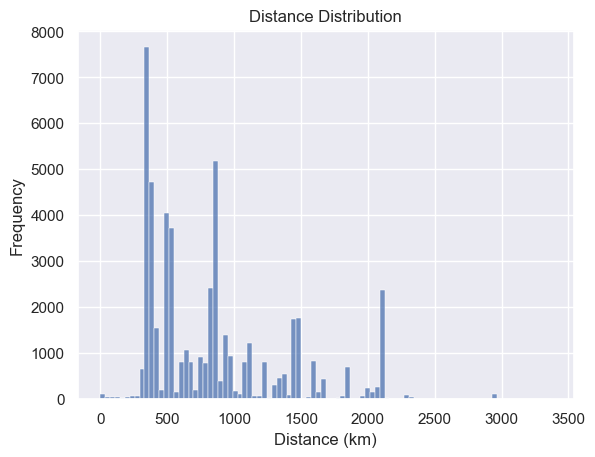

In [1383]:
sns.histplot(train_data['distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.show()

In [1384]:
train_data['median_distance'] = train_data.groupby('route')['distance'].transform('median')
route_median_mapping = train_data.set_index('route')['median_distance'].to_dict()
test_data['distance'] = test_data['route'].map(route_median_mapping)
train_data['distance'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance
0,4f0356600f61e3fcbea8ed8a137a2423,0,10,11,1,10,0.0,10,12,18.000000,13.000000,1,10000.000000,7.000000,1016.000000,18.000000,13.000000,3,10000.000000,7.000000,1014.000000,0,0,0,0,0,SBBR-SBSP,10,864.315493
1,865dbbbe74bebea18a71f24342516ff0,10,2,0,0,2,0.0,2,2,11.000000,6.000000,5,10000.000000,5.000000,1020.000000,11.000000,10.000000,0,1000.000000,8.000000,1020.000000,0,0,0,0,0,SBCT-SBSP,29,330.655063
2,1803af9cfc6a2c74d188481e3ffd848e,5,7,1,0,7,0.0,7,12,21.000000,18.000000,0,9000.000000,4.000000,1009.000000,21.000000,16.000000,0,10000.000000,5.000000,1010.000000,0,0,0,0,0,SBGR-SBPA,47,866.395791
3,f6af733a687f904183efd149ec713be5,2,11,3,0,11,0.0,11,11,25.000000,22.000000,2,10000.000000,9.000000,1016.000000,23.271724,12.354653,4,8745.982301,6.700308,1015.465165,0,0,0,0,0,SBCT-SBSV,30,1806.094706
4,6117f9ac60b7f66b740c9130be433313,9,5,0,0,5,0.0,5,5,22.633617,15.518738,4,9435.868415,7.257991,1017.077681,24.000000,4.000000,3,10000.000000,8.000000,1010.000000,0,0,0,0,0,SBGR-SBRJ,49,344.342100


In [1385]:
train_data.head()

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed,median_distance
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBKP-SBRJ,55,-23.049409,-47.089329,-22.918608,-43.162407,408.105110,363.492754,408.105110
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBGR-SBRJ,49,-23.408319,-46.407657,-22.912327,-43.161847,344.342100,324.048387,344.342100
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBBR-SBRJ,9,-15.878665,-47.894573,-22.913170,-43.160765,923.832189,395.265152,923.832189
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,5,10000.0,6.0,1018.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBCF-SBKP,17,-23.017542,-47.118901,-19.636025,-43.966203,497.150203,415.213333,497.150203
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,5,10000.0,5.0,1021.0,19.41236,10.615731,6,8315.915608,5.876631,1017.95242,SBCF-SBFL,14,-19.654805,-43.948362,-27.674720,-48.532466,1004.346329,357.903030,1004.346329


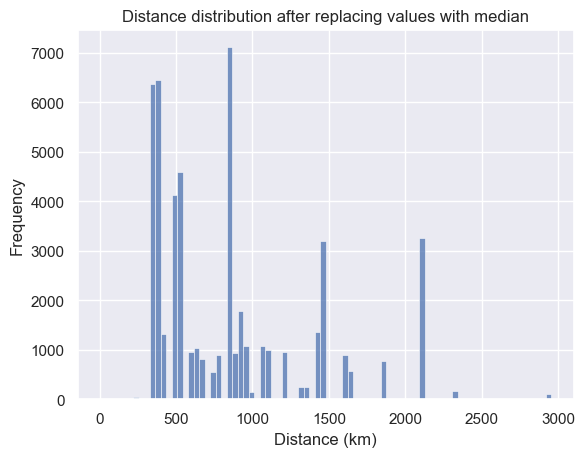

In [1386]:
sns.histplot(train_data['distance'])
plt.title('Distance distribution after replacing values with median')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [1387]:
grouped_counts = train_data.groupby('route_cat')['distance'].value_counts().reset_index(name='count')

# Sort the DataFrame by 'distance'
sorted_counts = grouped_counts.sort_values(by=['distance', 'count'], ascending=[True, False])

print(sorted_counts)

    route_cat     distance  count
43  SBGR-SBGR     5.198789      6
48  SBKP-SBKP     5.768742      1
11  SBCF-SBCF    34.098083      4
41  SBGL-SBRJ    63.906649      1
52  SBKP-SBSP    77.920520      2
..        ...          ...    ...
45  SBGR-SBRF  2090.421447   1486
50  SBKP-SBRF  2100.143664    515
59  SBRF-SBSP  2121.516546   1255
57  SBPA-SBSV  2307.140920    159
54  SBPA-SBRF  2952.756744    112

[64 rows x 3 columns]


In [1388]:
routes_to_remove = ['SBGR-SBGR', 'SBKP-SBKP', 'SBCF-SBCF']

train_data = train_data[~train_data['route_cat'].isin(routes_to_remove)]
sorted_counts = sorted_counts[~sorted_counts['route_cat'].isin(routes_to_remove)]

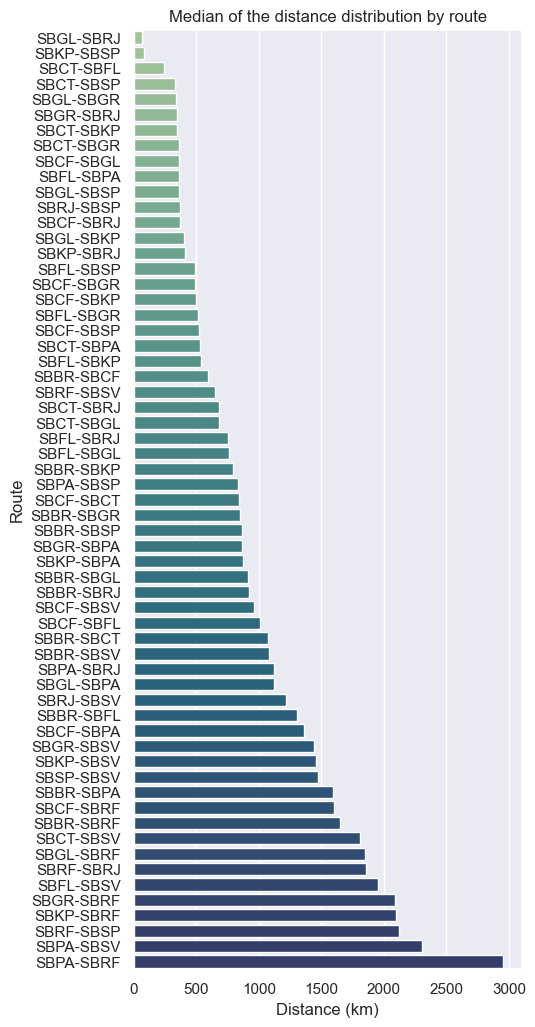

In [1389]:
plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
sns.barplot(x='distance', y='route_cat', data=sorted_counts, palette='crest')
plt.ylabel('Route')
plt.xlabel('Distance (km)')
plt.title('Median of the distance distribution by route')
plt.show()

In [1390]:
train_data['mean_speed'] = train_data.groupby('route')['speed'].transform('mean')
route_median_mapping = train_data.set_index('route')['mean_speed'].to_dict()
test_data['speed'] = test_data['route'].map(route_median_mapping)
train_data['speed'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance,speed
0,4f0356600f61e3fcbea8ed8a137a2423,0,10,11,1,10,0.0,10,12,18.000000,13.000000,1,10000.000000,7.000000,1016.000000,18.000000,13.000000,3,10000.000000,7.000000,1014.000000,0,0,0,0,0,SBBR-SBSP,10,864.315493,392.356073
1,865dbbbe74bebea18a71f24342516ff0,10,2,0,0,2,0.0,2,2,11.000000,6.000000,5,10000.000000,5.000000,1020.000000,11.000000,10.000000,0,1000.000000,8.000000,1020.000000,0,0,0,0,0,SBCT-SBSP,29,330.655063,311.745919
2,1803af9cfc6a2c74d188481e3ffd848e,5,7,1,0,7,0.0,7,12,21.000000,18.000000,0,9000.000000,4.000000,1009.000000,21.000000,16.000000,0,10000.000000,5.000000,1010.000000,0,0,0,0,0,SBGR-SBPA,47,866.395791,372.349192
3,f6af733a687f904183efd149ec713be5,2,11,3,0,11,0.0,11,11,25.000000,22.000000,2,10000.000000,9.000000,1016.000000,23.271724,12.354653,4,8745.982301,6.700308,1015.465165,0,0,0,0,0,SBCT-SBSV,30,1806.094706,371.456081
4,6117f9ac60b7f66b740c9130be433313,9,5,0,0,5,0.0,5,5,22.633617,15.518738,4,9435.868415,7.257991,1017.077681,24.000000,4.000000,3,10000.000000,8.000000,1010.000000,0,0,0,0,0,SBGR-SBRJ,49,344.342100,306.963359


In [1391]:
# plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
# sns.barplot(x='mean_speed', y='route_cat', data=sorted_counts, palette='crest')
# plt.ylabel('Route')
# plt.xlabel('Speed (km/h)')
# plt.title('Median of the distance distribution by route')
# plt.show()

In [1392]:
test_data

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance,speed
0,4f0356600f61e3fcbea8ed8a137a2423,0,10,11,1,10,0.0,10,12,18.000000,13.000000,1,10000.000000,7.000000,1016.000000,18.000000,13.000000,3,10000.000000,7.000000,1014.000000,0,0,0,0,0,SBBR-SBSP,10,864.315493,392.356073
1,865dbbbe74bebea18a71f24342516ff0,10,2,0,0,2,0.0,2,2,11.000000,6.000000,5,10000.000000,5.000000,1020.000000,11.000000,10.000000,0,1000.000000,8.000000,1020.000000,0,0,0,0,0,SBCT-SBSP,29,330.655063,311.745919
2,1803af9cfc6a2c74d188481e3ffd848e,5,7,1,0,7,0.0,7,12,21.000000,18.000000,0,9000.000000,4.000000,1009.000000,21.000000,16.000000,0,10000.000000,5.000000,1010.000000,0,0,0,0,0,SBGR-SBPA,47,866.395791,372.349192
3,f6af733a687f904183efd149ec713be5,2,11,3,0,11,0.0,11,11,25.000000,22.000000,2,10000.000000,9.000000,1016.000000,23.271724,12.354653,4,8745.982301,6.700308,1015.465165,0,0,0,0,0,SBCT-SBSV,30,1806.094706,371.456081
4,6117f9ac60b7f66b740c9130be433313,9,5,0,0,5,0.0,5,5,22.633617,15.518738,4,9435.868415,7.257991,1017.077681,24.000000,4.000000,3,10000.000000,8.000000,1010.000000,0,0,0,0,0,SBGR-SBRJ,49,344.342100,306.963359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40034,4e08052066073297c7a3c55798618324,11,8,20,0,8,0.0,8,12,27.000000,22.000000,4,10000.000000,15.000000,1013.000000,23.271724,12.354653,4,8745.982301,6.700308,1015.465165,0,0,0,0,0,SBRF-SBSV,64,644.906248,356.369834
40035,e22f120c65f5759aa8df576b59d71be3,2,10,8,0,10,0.0,10,12,22.633617,15.518738,4,9435.868415,7.257991,1017.077681,19.000000,10.000000,1,10000.000000,3.000000,1017.000000,0,0,0,0,0,SBCT-SBSP,29,330.655063,311.745919
40036,ca9399162037201a4d0c49c832a32739,5,1,11,0,1,0.0,1,12,13.000000,12.000000,4,9000.000000,3.000000,1018.000000,21.000000,9.000000,5,10000.000000,4.000000,1016.000000,0,0,0,0,0,SBCF-SBGR,16,490.689288,354.528109
40037,560136088f5f1493dbad809a3554172c,0,5,12,0,5,0.0,5,12,25.000000,10.000000,2,10000.000000,4.000000,1014.000000,25.000000,7.000000,1,10000.000000,10.000000,1012.000000,0,0,0,0,0,SBBR-SBGR,5,847.357197,396.357114


In [1393]:
train_data.describe()

,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route,start_lat,start_lon,final_lat,final_lon,distance,speed,median_distance,mean_speed
count,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000,52062.000000
mean,6.120894,6.295993,13.402366,4786.870789,0.104798,6.295993,0.376993,6.295993,10.524432,20.330533,14.004375,3.092889,9405.365762,6.699610,1019.125529,19.436569,10.636397,4.974089,8318.380923,5.887593,1017.949875,37.624851,-21.539433,-45.334266,-21.148223,-45.088080,850.595202,363.490713,850.595202,363.490713
std,3.553992,3.689711,5.998769,2283.550967,0.656622,3.689711,0.484638,3.689711,2.977543,5.002241,4.572988,2.060759,1534.182762,3.341454,3.554314,2.375050,1.942227,1.890218,1737.355575,1.661249,1.814963,21.467373,5.273183,3.969046,5.480406,4.159951,523.357592,40.443501,523.357592,40.443501
min,0.000000,0.000000,0.000000,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-6.000000,0.000000,200.000000,0.000000,998.000000,5.000000,-2.000000,0.000000,300.000000,0.000000,1006.000000,1.000000,-32.414917,-60.281707,-33.339338,-60.579401,63.906649,206.045995,63.906649,206.045995
25%,3.000000,3.000000,10.000000,2996.000000,0.000000,3.000000,0.000000,3.000000,11.000000,16.250000,11.000000,1.000000,9393.262032,4.000000,1017.000000,19.412360,10.615731,5.000000,8315.915608,5.876631,1017.952420,20.000000,-23.640340,-47.861150,-23.625753,-48.126665,408.105110,323.847823,408.105110,323.847823
50%,7.000000,7.000000,14.000000,4281.000000,0.000000,7.000000,0.000000,7.000000,12.000000,20.228182,13.960735,4.000000,10000.000000,6.695681,1019.190786,19.412360,10.615731,6.000000,8315.915608,5.876631,1017.952420,36.000000,-23.015509,-46.605781,-22.913626,-46.535589,755.358288,369.077540,755.358288,369.077540
75%,9.000000,10.000000,18.000000,5786.000000,0.000000,10.000000,1.000000,10.000000,12.000000,24.000000,17.000000,5.000000,10000.000000,9.000000,1022.000000,19.412360,10.615731,6.000000,8315.915608,5.876631,1017.952420,60.000000,-19.646762,-43.164692,-16.255829,-43.163855,1081.948610,396.357114,1081.948610,396.357114
max,11.000000,11.000000,23.000000,19408.000000,23.000000,11.000000,1.000000,11.000000,12.000000,31.000000,25.000000,7.000000,10000.000000,26.000000,1028.000000,30.000000,21.000000,7.000000,10000.000000,18.000000,1026.000000,68.000000,-5.107002,-34.866636,-1.389287,-34.838871,2952.756744,435.498831,2952.756744,435.498831


# Modeling

In [1394]:
train_data.shape

(52062, 32)

In [1395]:
features = train_data.columns
features = features.drop(['flightid', 'solution', 'start_lat', 'start_lon', 'final_lat', 'final_lon', 'median_distance', 'mean_speed','route_cat', 'visibility_prev', 'temperature_prev', 'pressure_prev'])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

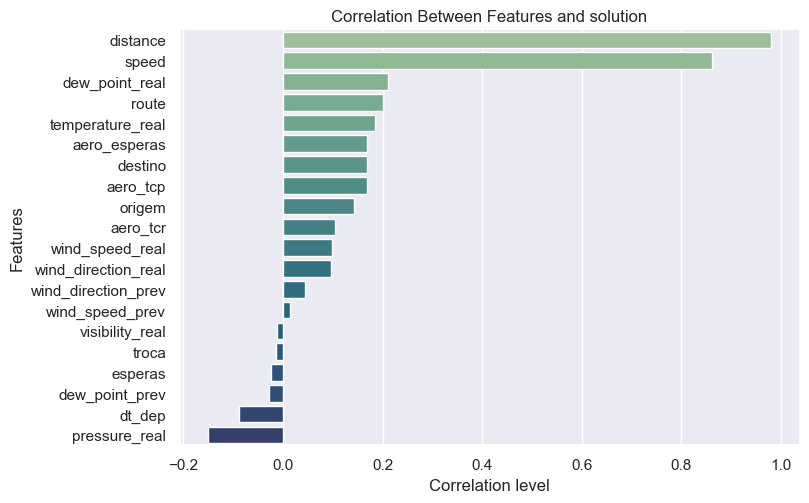

In [1396]:

correlation = pd.DataFrame()
correlation['correlation'] = [train_data[column].corr(train_data['solution'], method='pearson') for column in features if train_data[column].corr(train_data['solution'], method='pearson') != 0]
correlation['features'] = [features for features in features if train_data[features].corr(train_data['solution'], method='pearson') != 0]

correlation = correlation.sort_values(by='correlation', ascending=False)
plt.figure(figsize=(8, .3*len(correlation.correlation.unique())))
plt.title('Correlation Between Features and solution')
sns.barplot(data=correlation, x='correlation', y='features', orient='h', palette='crest')
plt.xlabel('Correlation level')
plt.ylabel('Features')
plt.show()

In [1397]:
train_data.to_csv('data/train_data.csv', index=False)

In [1398]:
# def objective(trial):
#     params = {
#         'objective': 'reg:squarederror',
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
#         'max_depth': trial.suggest_int('max_depth', 1, 20),
#         'alpha': trial.suggest_float('alpha', 0, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 1, 1000)
#     }

#     model = xgb.XGBRegressor(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_pred = np.round_(y_pred)
#     mse = mean_squared_error(y_test, y_pred)

#     return mse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_mse = study.best_value


# print(f'Best Hyperparameters: {best_params}')
# print(f'Best MSE: {best_mse}')

In [1399]:
# model_ideal = xgb.XGBRegressor()
# model_ideal.fit(X_train, y_train)
# y_pred_ideal = model_ideal.predict(X_test)
# y_pred_ideal = np.round_(y_pred_ideal)
# print(f'\nXGBoost Regressor MSE: {mean_squared_error(y_test, y_pred_ideal)}')

The model tested above utilized Optuna for hyperparameter optimization and employed a train-test split for validation, leading to its superior performance. On the contrary, the most successful submission was achieved using a model that used hand-tested parameters rather than the default or the optimized ones. This performance difference may be explained by the potential dissimilarities between the training data and the submission data. The training set could contain more instances with extreme variable values compared to the provided test set. This can lead to less accurate predictions when the model is fine-tuned exclusively for the training data.

In [1400]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)
print(f'\nXGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')

#77884.43064920054: 20,346


XGBoost Regressor MSE: 90219.70229520791


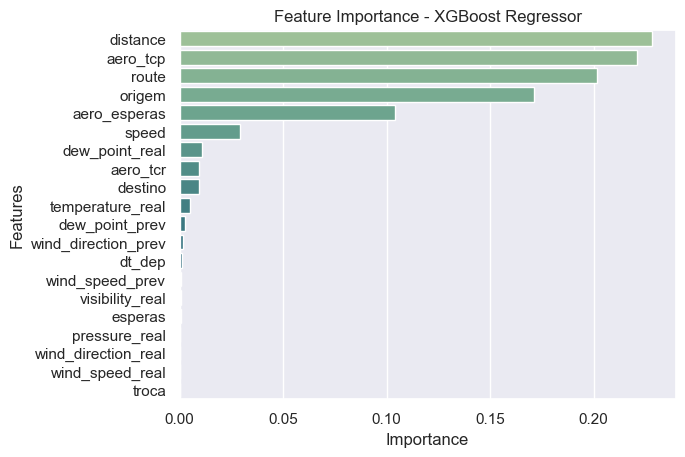

In [1401]:
sns.barplot(data=pd.DataFrame({'features':features, 'importance':model.feature_importances_}).sort_values(by='importance', ascending=False), x='importance', y='features', orient='h', palette='crest')
plt.title('Feature Importance - XGBoost Regressor')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

## Comparing model with predictions made in 2022

In [1402]:
# delays_hist = y_test - y_pred
# delays_hist = [delay / 60 for delay in delays_hist if -30 <= delay // 60 <= 30]
# bins = int(max(delays_hist) - min(delays_hist) + 1)

# conditions = [
#     {'condition': '<= -30 mins', 'color': (0.416, 0.349, 0.122), 'range': (-float('inf'), -29)},
#     {'condition': '-30 to -15 mins', 'color': (0.620, 0.518, 0.200), 'range': (-30, -16)},
#     {'condition': '-15 to -5 mins', 'color': (0.898, 0.812, 0.486), 'range': (-16, -5)},  
#     {'condition': '-5 to 0', 'color': (0.255, 0.573, 0.953), 'range': (-6, 0)},  
#     {'condition': '0', 'color': (0.502, 0.502, 0.502), 'range': (-1, 1)},  
#     {'condition': '0 to 5 mins', 'color': (0.827, 0.439, 0.282), 'range': (0, 6)},  
#     {'condition': '5 to 15 mins', 'color': (0.843, 0.576, 0.592), 'range': (5, 16)},
#     {'condition': '15 to 30 mins', 'color': (0.573, 0.231, 0.251), 'range': (15, 30)},
#     {'condition': '> 30 mins', 'color': (0.380, 0.153, 0.165), 'range': (29, float('inf'))}  
# ]

# fig, ax = plt.subplots(figsize=(20, 10))
# fig.patch.set_facecolor((51/255, 51/255, 51/255))
# ax.set_title('Distribution of delays (Best Kaggle Model)', color='white')
# ax.set_xlabel('Delay (min)', color='white')
# ax.set_ylabel('Frequency', color='white')
# ax.set_xticks(range(-200, 201, 5))

# # Change the background color inside the axes
# ax.set_facecolor((51/255, 51/255, 51/255))
# ax.grid(True, linestyle='dotted', linewidth=0.5, color=(118/255, 118/255, 116/255))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# # Create a histogram with custom colors and no bin edges
# n, bins, _ = ax.hist(delays_hist, bins=bins, color='lightgray', edgecolor='none')

# used_labels = set()

# # Adjust the colors based on conditions
# for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
#     for condition in conditions:
#         if condition['range'][0] <= start and condition['range'][1] >= end:
#             if condition['condition'] not in used_labels:
#                 ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3, label=condition['condition'])
#                 used_labels.add(condition['condition'])
#             else:
#                 ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3)
# for text in ax.get_xticklabels() + ax.get_yticklabels():
#     text.set_color('white')

# ax.legend()
# plt.show()

# delays_hist = y_test - y_pred_ideal
# delays_hist = [delay / 60 for delay in delays_hist if -30 <= delay // 60 <= 30]
# bins = int(max(delays_hist) - min(delays_hist) + 1)

# conditions = [
#     {'condition': '<= -30 mins', 'color': (0.416, 0.349, 0.122), 'range': (-float('inf'), -29)},
#     {'condition': '-30 to -15 mins', 'color': (0.620, 0.518, 0.200), 'range': (-30, -16)},
#     {'condition': '-15 to -5 mins', 'color': (0.898, 0.812, 0.486), 'range': (-16, -5)},  
#     {'condition': '-5 to 0', 'color': (0.255, 0.573, 0.953), 'range': (-6, 0)},  
#     {'condition': '0', 'color': (0.502, 0.502, 0.502), 'range': (-1, 1)},  
#     {'condition': '0 to 5 mins', 'color': (0.827, 0.439, 0.282), 'range': (0, 6)},  
#     {'condition': '5 to 15 mins', 'color': (0.843, 0.576, 0.592), 'range': (5, 16)},
#     {'condition': '15 to 30 mins', 'color': (0.573, 0.231, 0.251), 'range': (15, 30)},
#     {'condition': '> 30 mins', 'color': (0.380, 0.153, 0.165), 'range': (29, float('inf'))}  
# ]

# fig, ax = plt.subplots(figsize=(20, 10))
# fig.patch.set_facecolor((51/255, 51/255, 51/255))
# ax.set_title('Distribution of delays (Ideal Model)', color='white')
# ax.set_xlabel('Delay (min)', color='white')
# ax.set_ylabel('Frequency', color='white')
# ax.set_xticks(range(-200, 201, 5))

# # Change the background color inside the axes
# ax.set_facecolor((51/255, 51/255, 51/255))
# ax.grid(True, linestyle='dotted', linewidth=0.5, color=(118/255, 118/255, 116/255))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# # Create a histogram with custom colors and no bin edges
# n, bins, _ = ax.hist(delays_hist, bins=bins, color='lightgray', edgecolor='none')

# used_labels = set()

# # Adjust the colors based on conditions
# for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
#     for condition in conditions:
#         if condition['range'][0] <= start and condition['range'][1] >= end:
#             if condition['condition'] not in used_labels:
#                 ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3, label=condition['condition'])
#                 used_labels.add(condition['condition'])
#             else:
#                 ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3)
# for text in ax.get_xticklabels() + ax.get_yticklabels():
#     text.set_color('white')

# ax.legend()
# plt.show()



Current predictions

![ELDT ITA predictions](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F16677057%2F0d27208d107356e2ef0b16582b9c9799%2FUntitled.png?generation=1694384282991412&alt=media)

By comparing the two histograms above, being the first one the predictions made by the model created in this notebook and the second one being the ELDTs predicted in the year of 2022, it is possible to see that the model is able to predict the ELDTs with with an even better performance than the model that was used to predict the ELDTs in 2022. Although those are good results, it is important to emphasize that the model is making predictions based on a limited number of routes within the brazilian airspace, which means that the model could potentially perform worse if it was used to predict ELDTs for flights in other routes or even in other countries.

# Submission

In [1403]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

for id in test_data.query('origem == destino')['flightid']:
    output.loc[output['ID'] == id, 'solution'] = 0

output.to_csv('data/submission.csv', index=False)

In [1404]:
output.query('solution == 0')

,ID,solution
1244,3944af86a08b4061cbb61027265f0e23,0.0
3515,3a368308dda64874d6d554fb662103a4,0.0
5525,c729f371c4766fa3e98a0c7ad4f12184,0.0
8095,24643636805deafb6309d3a0d380ea93,0.0
9422,239e4acc0ecf7daea3de6f84689b4254,0.0
17851,589c53af316be215901956bf7d0751b6,0.0
18660,8ebbe4bec2ecbeeb4ae4acf51ba068cd,0.0
25192,224fcd5a5cb552e81cb842f63b770133,0.0
27854,5539764c4bc98314792e02fe07a2864f,0.0
29455,917637382edb918d5513c95cdf784d81,0.0
